# Analysis of the impact of channels on the Movement Recognition task in execution trials

In this notebook, we analyze the impact on accuracy of the number of channels used for training the models. We add channels by ascending order of their p-value on the responsive t-test.

### Import librairies

In [1]:
from utils import *
from dataset import *
from constants import *
from models.BaseModels import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from dataset import Participant

# Reproducibility
seed_num = RANDOM_STATE # This seed will be used for all random number generators
random.seed(seed_num) # Python's random will use seed_num
np.random.seed(seed_num) # NumPy's random number generator will use seed_num

### Data loading

Change here the participant to load.

In [2]:
use_saved = True
part_name = 's6'

In [3]:
if use_saved and os.path.exists(f'saved/{part_name}.pkl'):
    participant = Participant.load_from_pickle(f'saved/{part_name}.pkl')
else:
    participant = Participant(part_name, data_path=DATA_PATH_NOTEBOOK, alpha=ALPHA)
    saved_dir = os.path.join(os.getcwd(), 'saved')
    if not os.path.exists(saved_dir):
        os.makedirs(saved_dir)
    with open(f'saved/{part_name}.pkl', 'wb') as f:
        pickle.dump(participant, f, pickle.HIGHEST_PROTOCOL)

In [4]:
test_size = 0.3
pca_expl_var = 0.95

## Execution

<span style='color: red'>WARNING</span>: computing all features takes up to 26 minutes for (participant s12) (Intel Core i7-7700K)

In [5]:
ex_features_dict = {}

for channel_idx in range(len(participant.relevant_channels_ex)):
    ex_features_dict[channel_idx] = participant.get_features_all_sessions_mvt('E', channels=[channel_idx])

100%|██████████| 256/256 [00:07<00:00, 33.61it/s]


### Run models

In [6]:
logreg_accuracies = []
logreg_pca_accuracies = []
svm_accuracies = []
svm_pca_accuracies = []
rf_accuracies = []

y = ex_features_dict[0]['label']
for top_channels in range(1, len(participant.relevant_channels_ex)+1):
    ex_features = pd.concat([ex_features_dict[i].drop('label', axis=1) for i in range(top_channels)], axis=1)
    print(f'The dataset contains {ex_features.shape[0]} samples and {ex_features.shape[1]} features.')
    print(f'The {len(participant.relevant_channels_ex[:top_channels])} most relevant channels are located in the following locations:')
    regions = [participant.channels_locations[i] for i in [channel.idx for channel in participant.relevant_channels_ex[:top_channels]]]
    channels_per_regions = {}
    for region in set(regions):
        channels_per_regions[region] = regions.count(region)
    print(channels_per_regions)

    X_train, X_test, y_train, y_test = train_test_split(ex_features, y, test_size=test_size, random_state=RANDOM_STATE)
    logreg = LogisticRegressionModel()
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    logreg_accuracies.append(accuracy)
    print(f"LogReg Accuracy: {accuracy:.2f}")
    logreg = LogisticRegressionModel(use_pca=True, expl_var=pca_expl_var)
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    logreg_pca_accuracies.append(accuracy)
    print(f"LogReg PCA Accuracy: {accuracy:.2f}")
    svm = SVMModel()
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    svm_accuracies.append(accuracy)
    print(f"SVM Accuracy: {accuracy:.2f}")
    svm = SVMModel(use_pca=True, expl_var=pca_expl_var)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    svm_pca_accuracies.append(accuracy)
    print(f"SVM PCA Accuracy: {accuracy:.2f}")
    svm = RandomForestModel()
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    rf_accuracies.append(accuracy)
    print(f"RF Accuracy: {accuracy:.2f}")

The dataset contains 128 samples and 72 features.
The 1 most relevant channels are located in the following locations:
{'postcentral': 1}
LogReg Accuracy: 0.54
LogReg PCA Accuracy: 0.51
SVM Accuracy: 0.41
SVM PCA Accuracy: 0.41
RF Accuracy: 0.51
The dataset contains 128 samples and 144 features.
The 2 most relevant channels are located in the following locations:
{'supramarginal': 1, 'postcentral': 1}
LogReg Accuracy: 0.74
LogReg PCA Accuracy: 0.74
SVM Accuracy: 0.72
SVM PCA Accuracy: 0.67
RF Accuracy: 0.72
The dataset contains 128 samples and 216 features.
The 3 most relevant channels are located in the following locations:
{'supramarginal': 1, 'precentral': 1, 'postcentral': 1}
LogReg Accuracy: 0.72
LogReg PCA Accuracy: 0.72
SVM Accuracy: 0.67
SVM PCA Accuracy: 0.64
RF Accuracy: 0.64
The dataset contains 128 samples and 288 features.
The 4 most relevant channels are located in the following locations:
{'supramarginal': 1, 'precentral': 2, 'postcentral': 1}
LogReg Accuracy: 0.64
LogRe

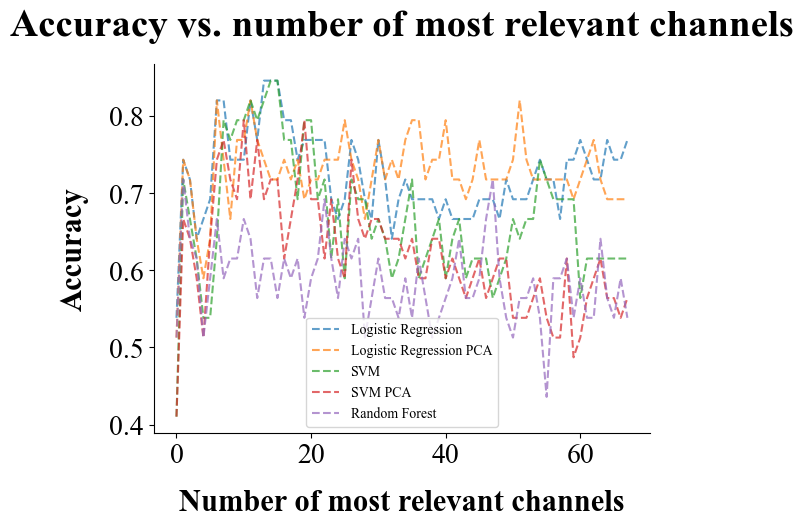

In [10]:
# General
plt.rcParams["font.family"] = "Times New Roman"
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE, titleweight = 'bold', titlepad = 20)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE, labelweight = 'bold', labelpad = 15)   # fontsize of the x and y labels    
plt.rc('xtick', labelsize=SMALL_SIZE, direction = 'out')    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE, direction = 'out')    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes.spines', top=False, right=False)  # Removing the top and right spines   

plt.plot(logreg_accuracies, '--', alpha=0.7, label='Logistic Regression')
plt.plot(logreg_pca_accuracies, '--', alpha=0.7, label='Logistic Regression PCA')
plt.plot(svm_accuracies, '--', alpha=0.7, label='SVM')
plt.plot(svm_pca_accuracies, '--', alpha=0.7, label='SVM PCA')
plt.plot(rf_accuracies, '--', alpha=0.7, label='Random Forest')
plt.legend(fontsize=10)
plt.xlabel('Number of most relevant channels')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. number of most relevant channels')
plt.show()